In [202]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [203]:
!wget https://lazyprogrammer.me/course_files/exercises/ecoli.csv

--2025-09-01 11:19:41--  https://lazyprogrammer.me/course_files/exercises/ecoli.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19487 (19K) [text/csv]
Saving to: ‘ecoli.csv.1’

ecoli.csv.1         100%[===================>]  19.03K  --.-KB/s    in 0s      

2025-09-01 11:19:42 (69.4 MB/s) - ‘ecoli.csv.1’ saved [19487/19487]



In [204]:
!ls

ecoli.csv  ecoli.csv.1	sample_data


In [205]:
df = pd.read_csv('ecoli.csv', sep=r'\s+', header=None)

In [206]:
df.head()

,0,1,2,3,4,5,6,7,8
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       336 non-null    object 
 1   1       336 non-null    float64
 2   2       336 non-null    float64
 3   3       336 non-null    float64
 4   4       336 non-null    float64
 5   5       336 non-null    float64
 6   6       336 non-null    float64
 7   7       336 non-null    float64
 8   8       336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


In [208]:
print(df);

              0     1     2     3    4     5     6     7   8
0     AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35  cp
1    ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44  cp
2    ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46  cp
3    ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36  cp
4     ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35  cp
..          ...   ...   ...   ...  ...   ...   ...   ...  ..
331  TREA_ECOLI  0.74  0.56  0.48  0.5  0.47  0.68  0.30  pp
332  UGPB_ECOLI  0.71  0.57  0.48  0.5  0.48  0.35  0.32  pp
333  USHA_ECOLI  0.61  0.60  0.48  0.5  0.44  0.39  0.38  pp
334  XYLF_ECOLI  0.59  0.61  0.48  0.5  0.42  0.42  0.37  pp
335  YTFQ_ECOLI  0.74  0.74  0.48  0.5  0.31  0.53  0.52  pp

[336 rows x 9 columns]


In [209]:
# gather X and Y
df_float = df.to_numpy()
X = df_float[:, 1:-1]
Y = df_float[:, -1].reshape(-1, 1) # convert 1D to 2D array
labels = list(set(Y.flatten()))
print(f'Shape of X: {np.shape(X)}')
print(f'Shape of Y: {np.shape(Y)}')
print(f'Labels: {labels}')

Shape of X: (336, 7)
Shape of Y: (336, 1)
Labels: ['im', 'om', 'omL', 'imS', 'pp', 'cp', 'imL', 'imU']


In [210]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
# targets: array([0, 1, 2, 3, 4])

targets = torch.as_tensor(targets)
# targets: tensor([0, 1, 2, 3, 4])

print(targets) # the labels are numbered in alphabetic order, numbers appear in order of labels
print(len(targets))

tensor([1, 5, 6, 3, 7, 0, 2, 4])
8


In [211]:
# separate intro train and test sets
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y,
                                                test_size=0.40)

In [212]:
Xtr = torch.from_numpy(Xtrain.astype(np.float32))
# Ytr = torch.from_numpy(Ytrain.astype(np.float32)).reshape(-1, 1)
Ytr = le.fit_transform(Ytrain.ravel())
Ytr = torch.as_tensor(Ytr)
Xte = torch.from_numpy(Xtest.astype(np.float32))
# Yte = torch.from_numpy(Ytest.astype(np.float32)).reshape(-1, 1)
Yte = le.fit_transform(Ytest.ravel())
Yte = torch.as_tensor(Yte)

In [221]:
X_mean, X_std = Xtr.mean(0, keepdim=True), Xtr.std(0, keepdim=True) + 1e-6
Xtr = (Xtr - X_mean) / X_std
Xte = (Xte - X_mean) / X_std  # use train stats!

In [223]:
print('x train:', Xtr.shape)
print('y train:', Ytr.shape)
print('x test:', Xte.shape)
print('y test:', Yte.shape)

x train: torch.Size([201, 7])
y train: torch.Size([201])
x test: torch.Size([135, 7])
y test: torch.Size([135])


In [224]:
# build the model
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Linear(16, 8)
)
# no need for final softmax!

In [225]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=7, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8, bias=True)
)

In [226]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [227]:
# DATA LOADER
# generates batches in the training loop

train_dataset = torch.utils.data.TensorDataset(Xtr, Ytr)
test_dataset = torch.utils.data.TensorDataset(Xte, Yte)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


In [228]:
n_epochs = 60

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    # we will save the loss of each batch in train_loss and compute the mean
    train_loss = []
    test_loss = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass (prediction)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # backward and optimize
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # here, we DO NOT ZERO the parameter gradients
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # NO BACKWARD PASS because not training anymore
        test_loss.append(loss.item())

    train_losses[it] = np.mean(train_loss)
    test_losses[it] = np.mean(test_loss)


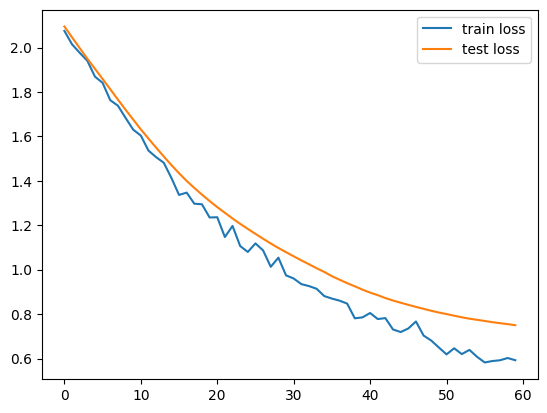

In [229]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show();